In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv
import copy
import warnings
warnings.filterwarnings('ignore')

# name and files for the simulation studied

name = '_DPPC_DIPC_chol_352_5GM1'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/'

path2 = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol_GM1_5/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_GM1_5_43nm_10ms_mb_fixed_t1.xtc'

In [2]:
# name and files for the simulation studied

name = '_DPPC_DIPC_chol'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/'

path2 = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/dynamics/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

In [3]:
# load gro and xtc files
u = mda.Universe( path+fgro, path+fxtc)

In [4]:
sel_all = u.select_atoms("all and resname DPPC")

In [5]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all)
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

# boucle pour travailler sur des frames de la simu

tmes = 1000
for ts in u.trajectory:
     if (ts.frame%tmes == 0):
            print(ts.frame)
            xmin=0
            ymin=0
            str_sel= "(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and (name GL1 or name AM1)"
            patch = u.select_atoms(str_sel).positions
            
            Lo = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name PO4 and resname DPPC").positions
            Ld = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name PO4 and resname DIPC").positions
            GM1 = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name AM1").positions
            chol = u.select_atoms("(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and name ROH").positions

            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            N = 15
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
            plt.scatter(Lo[:,1]/N, -Lo[:,0]/N, marker='.', c='yellow', s=2)
            plt.scatter(Ld[:,1]/N, -Ld[:,0]/N, marker='.', c='b', s=2)
            plt.scatter(GM1[:,1]/N, -GM1[:,0]/N, marker='+', c='g', s=2)
            plt.savefig(path2+'t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
            #pour enregistrer les plots


In [6]:
# needed functions for the local curvature computation

def F_neigh(n) :
    neigh[0] = n
    i=n%N
    j=int(n/N)
    ip1=(i+1)%N
    im1=(i-1)%N
    jp1=(j+1)%N
    jm1=(j-1)%N
    neigh[1] = ip1+N*j
    neigh[2] = im1+N*j
    neigh[3] = i+N*jm1
    neigh[4] = i+N*jp1

def Lap(n) :
    lap = ( h[neigh[4]]+h[neigh[3]]-2*h[neigh[0]] ) / dx**2 + ( h[neigh[1]]+h[neigh[2]]-2*h[neigh[0]] ) / dy**2
    return(lap)


5000
6000
7000
8000
9000


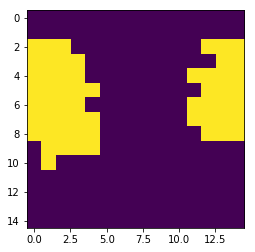

In [8]:
# boucle pour calculer la courbure au cours du temps
Ct_Lo = []
t = []

tmes = 1000

threshold = 0.6 # composition threshold from which the box is considered Lo, below it is considered Ld

#threshold2 = 0.6 a voir pour la frontiere

for ts in u.trajectory:
     if (ts.frame%tmes == 0 and ts.frame>=5000):
            print(ts.frame)
            xmin=0
            ymin=0
            str_sel= "(prop x> "+str(xmin)+" and prop y> "+str(ymin)+") and (name GL1 or name AM1)"
            patch = u.select_atoms(str_sel).positions
            
            xmax = max(patch[:,0])
            ymax = max(patch[:,1])
            
            xmin = min(patch[:,0])
            ymin = min(patch[:,1])
            
            N = 15
            dx = (xmax-xmin)/N
            dy = (ymax-ymin)/N
           
            Lf = mda.analysis.leaflet.LeafletFinder(u, 'name GL1 or name AM1')
            leaflet0 = Lf.groups(0)
            leaflet1 = Lf.groups(1)
            
            # lower leaflet
            bary0 = []

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy
                    str_sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and (name GL1 or name AM1)"
                    b0=leaflet0.select_atoms(str_sel).centroid().tolist()
                    bary0.append(b0)
                    
            # upper leaflet
            bary1 = []

            Mphi1 = np.zeros((N,N))

            for i in range(0,N):
                xs = xmin + i*dx
                for j in range(0,N):
                    ys = ymin + j*dy
                    str_sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and (name GL1 or name AM1)"
                    b1=leaflet1.select_atoms(str_sel).centroid().tolist()
                    bary1.append(b1)
        
                    sel_tot= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                    tot1= leaflet1.select_atoms(sel_tot).positions
                    n_tot1=len(tot1) # total number of molecules
        
                    sel_Ld= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
                    Ld1= leaflet1.select_atoms(sel_Ld).positions
                    n_Ld1=len(Ld1) # number of molecules in the Lo phase (DPPC here)
        
                    phi1=n_Ld1/n_tot1
                    Mphi1[i,j]=phi1

            Mphi1_bin = np.zeros((N,N))

            for i in range(N):
                for j in range(N):
                    if Mphi1[i,j]>= threshold :
                        Mphi1_bin[i,j]=1

            
            plt.imshow(Mphi1_bin)
            plt.savefig(path2+'phi_bin_t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
            
            bary0=np.array(bary0)
            bary1=np.array(bary1)
            
            neigh = [0,0,0,0,0]
            h=bary1[:,2]
            laplacian = []
            
            for i in range(N*N) :
                F_neigh(i)
                laplacian.append(Lap(i))
                
            curv = copy.copy(bary1)
            curv[:,2] = laplacian
            C = curv[:,2]
            C.shape=(N,N)
            
            t.append(ts.frame)

            # if the phase of the box is Lo then the curvature is averaged
            C_Lo = []
            for i in range(N):
                for j in range(N):
                    if Mphi1_bin[i,j] == 1 :
                        C_Lo.append(C[i,j])
                        
            Ct_Lo.append(np.mean(C_Lo))
            #print(C_Lo)
            #print(Ct_Lo)


[0.001699907990378131, -0.0045052811028672155, -0.0016473939645237563, -0.0037748380904496013, -0.00311648028907838, -0.003535494073439776, -0.005372029828376561, -0.004332381019143591, -0.003687164917363881, -0.001959826653270313]


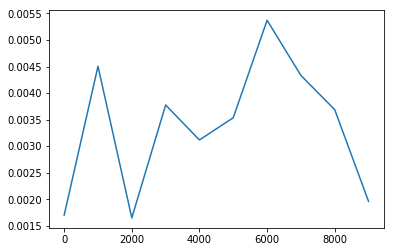

In [28]:
print(Ct_Lo)
plt.plot(t,np.abs(Ct_Lo))

# need to do the same for the thickness

# Diffusion

In [14]:
# boucle pour suivre un lipide pendant la trajectoire pour calculer le MSD et le coeff de diffusion
tmes = 10
traj = []
for ts in u.trajectory:
     if (ts.frame%tmes == 0):
            #print(ts.frame)
            str_sel= "name GL1 and resname DIPC"
            p = u.select_atoms(str_sel).positions
            traj.append(p)
            


(1000, 3364, 3)


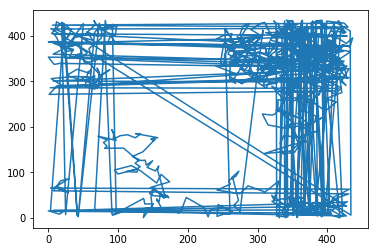

In [15]:
t = np.array(traj)
nbr=22 # indice du lipide que l'on suit
print(np.shape(t)) # nb de frames - indice du lipide - coordonnées
x=t[:,nbr,0]
y=t[:,nbr,1]
plt.plot(x,y)